# Create datasets for models

In [1]:
# Import packages
import pandas as pd
import numpy as np
np.random.seed(42) # set seed for reproducibility
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

c:\Users\Usuario\.conda\envs\GRL_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load datasets
ratings = pd.read_csv('../raw_data/ml-25m/ratings.csv')
movies = pd.read_csv('../raw_data/ml-25m/movies.csv')
genome_scores = pd.read_csv('../raw_data/ml-25m/genome-scores.csv')

df_rows = {
    'ratings': ratings.shape[0],
    'movies': movies.shape[0],
    'genome_scores': genome_scores.shape[0],
}
print(df_rows)

{'ratings': 25000095, 'movies': 62423, 'genome_scores': 15584448}


## Pre-processing

In [3]:
# Positive rating
ratings['positive_rating'] = ratings['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Negative rating
ratings['negative_rating'] = ratings['rating'].apply(lambda x: 1 if x <= 2.5 else 0)

# Timestamps for ratings
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
# ratings['year'] = ratings['timestamp'].dt.year
ratings['year_month'] = ratings['timestamp'].dt.to_period('M')

ratings.head()

,userId,movieId,rating,timestamp,positive_rating,negative_rating,year_month
0,1,296,5.0,2006-05-17 15:34:04,1,0,2006-05
1,1,306,3.5,2006-05-17 12:26:57,0,0,2006-05
2,1,307,5.0,2006-05-17 12:27:08,1,0,2006-05
3,1,665,5.0,2006-05-17 15:13:40,1,0,2006-05
4,1,899,3.5,2006-05-17 12:21:50,0,0,2006-05


In [4]:
# Movie premier year
movies['premier_year'] = movies['title'].str.extract(r'\((\d{4})\)')
# Convert to int
movies['premier_year'] = pd.to_numeric(movies['premier_year'], errors='coerce').astype('Int64')
# Note: there are some ratings that were done after the premier year. So this variable is not completely OK.

# Movie genres
movies['genre_list'] = movies['genres'].str.split('|')
movies.drop(columns=['genres'], inplace=True)
# When genre is '(no genres listed)', we set it to an empty list
movies['genre_list'] = movies['genre_list'].apply(lambda x: [] if x == ['(no genres listed)'] else x)
# Count number of genres per movie
movies['num_genres'] = movies['genre_list'].str.len()

# # One hot encode genres
# movies_genres = movies['genre_list'].explode().str.get_dummies().groupby(level=0).sum()
# movies = movies.join(movies_genres)
# del movies_genres

# Create column in movies with the amount of ratings per movie
ratings_per_movie = ratings.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie.rename(columns={'rating': 'num_ratings_origdata'}, inplace=True)
movies = movies.merge(ratings_per_movie, on='movieId', how='left')

# Create column in movies with the amount of positive ratings per movie
positive_ratings_per_movie = ratings.groupby('movieId')['positive_rating'].sum().reset_index()
positive_ratings_per_movie.rename(columns={'positive_rating': 'num_positive_ratings_origdata'}, inplace=True)
movies = movies.merge(positive_ratings_per_movie, on='movieId', how='left')

# Create column in movies with the amount of negative ratings per movie
negative_ratings_per_movie = ratings.groupby('movieId')['negative_rating'].sum().reset_index()
negative_ratings_per_movie.rename(columns={'negative_rating': 'num_negative_ratings_origdata'}, inplace=True)
movies = movies.merge(negative_ratings_per_movie, on='movieId', how='left')

# Average rating per movie
ratings_per_movie = ratings.groupby('movieId')['rating'].mean().reset_index()
ratings_per_movie.rename(columns={'rating': 'avg_rating_origdata'}, inplace=True)
movies = movies.merge(ratings_per_movie, on='movieId', how='left')

del ratings_per_movie, positive_ratings_per_movie, negative_ratings_per_movie

movies.head()

,movieId,title,premier_year,genre_list,num_genres,num_ratings_origdata,num_positive_ratings_origdata,num_negative_ratings_origdata,avg_rating_origdata
0,1,Toy Story (1995),1995,"[Adventure, Animation, Children, Comedy, Fantasy]",5,57309.0,37709.0,4659.0,3.893708
1,2,Jumanji (1995),1995,"[Adventure, Children, Fantasy]",3,24228.0,8276.0,5402.0,3.251527
2,3,Grumpier Old Men (1995),1995,"[Comedy, Romance]",2,11804.0,3674.0,2772.0,3.142028
3,4,Waiting to Exhale (1995),1995,"[Comedy, Drama, Romance]",3,2523.0,637.0,867.0,2.853547
4,5,Father of the Bride Part II (1995),1995,[Comedy],1,11714.0,3161.0,2937.0,3.058434


## Subsetting

In [5]:
ratings_subset = ratings.copy()
movies_subset = movies.copy()
genome_scores_subset = genome_scores.copy()

### Users-Ratings
The users in the dataset have 20 ratings or more.

There are not duplicated user-ratings pairs.


<span style="color:green">***USE THE FOLLOWING CELL TO PRODUCE A SUBSAMPLE OF THE FULL DATASET:***</span>


In [6]:
# OPTIONAL: set to True and run entire script to get the smaller version of the dataset
get_smaller_dataset = False

# RANDOM SELECTION: only keep the ratings from K% of the users
if get_smaller_dataset:
    k = 0.1
    users = ratings_subset['userId'].unique()
    valid_users = np.random.choice(users, int(len(users) * k), replace=False)
    ratings_subset = ratings_subset[ratings_subset['userId'].isin(valid_users)]

    print("Number of ratings before filtering: ", df_rows['ratings'])
    print("Number of ratings after filtering: ", ratings_subset.shape[0])
    print("Rows lost: ", df_rows['ratings'] - ratings_subset.shape[0], "(", 
          round((df_rows['ratings'] - ratings_subset.shape[0]) / df_rows['ratings'] * 100, 2), "%)")
    df_rows['ratings'] = ratings_subset.shape[0]
else:
    print("No random selection applied. Using the entire dataset.")

No random selection applied. Using the entire dataset.


In [7]:
# Keep ratings from users who made their last rating in 2016 or later
ratings_subset['last_rating_year'] = ratings_subset.groupby('userId')['year_month'].transform('max')
ratings_subset = ratings_subset[ratings_subset['last_rating_year'] >= '2016-01']

print("Number of ratings before filtering: ", df_rows['ratings'])
print("Number of ratings after filtering: ", ratings_subset.shape[0])
print("Rows lost: ", df_rows['ratings'] - ratings_subset.shape[0], "(", round((df_rows['ratings'] - ratings_subset.shape[0]) / df_rows['ratings'] * 60, 2), "%)")
df_rows['ratings'] = ratings_subset.shape[0]

Number of ratings before filtering:  25000095
Number of ratings after filtering:  8470588
Rows lost:  16529507 ( 39.67 %)


In [8]:
# Discard ratings that are not positive or negative
positive_or_negative_rating = (ratings_subset['positive_rating'] == 1) | (ratings_subset['negative_rating'] == 1)
ratings_subset = ratings_subset[positive_or_negative_rating]

print("Number of ratings before filtering: ", df_rows['ratings'])
print("Number of ratings after filtering: ", ratings_subset.shape[0])
print("Rows lost: ", df_rows['ratings'] - ratings_subset.shape[0], "(", round((df_rows['ratings'] - ratings_subset.shape[0]) / df_rows['ratings'] * 50, 2), "%)")
df_rows['ratings'] = ratings_subset.shape[0]

Number of ratings before filtering:  8470588
Number of ratings after filtering:  5649489
Rows lost:  2821099 ( 16.65 %)


In [9]:
# Only keep ratings from users that made at least 5 positive ratings
users_positive_rating_count = ratings.groupby('userId')['positive_rating'].sum()
users_at_least_5_positive_ratings = users_positive_rating_count[users_positive_rating_count >= 5].index.tolist()

# Subset
ratings_subset = ratings_subset[ratings_subset['userId'].isin(users_at_least_5_positive_ratings)]

print("Number of ratings before filtering: ", df_rows['ratings'])
print("Number of ratings after filtering: ", ratings_subset.shape[0])
print("Rows lost: ", df_rows['ratings'] - ratings_subset.shape[0], "(", round((df_rows['ratings'] - ratings_subset.shape[0]) / df_rows['ratings'] * 50, 2), "%)")
df_rows['ratings'] = ratings_subset.shape[0]

Number of ratings before filtering:  5649489
Number of ratings after filtering:  5641306
Rows lost:  8183 ( 0.07 %)


In [10]:
# Remove ratings from users with more than 200 ratings

# Count the amount of ratings per user
ratings_per_user = ratings_subset.groupby('userId').size().reset_index(name='count')

# Get the users with more than 200 ratings
very_active_users = ratings_per_user[ratings_per_user['count'] > 200]['userId']

# Remove very active users
ratings_subset = ratings_subset[~ratings_subset['userId'].isin(very_active_users)]
del ratings_per_user, very_active_users

print("Number of ratings before filtering: ", df_rows['ratings'])
print("Number of ratings after filtering: ", ratings_subset.shape[0])
print("Rows lost: ", df_rows['ratings'] - ratings_subset.shape[0], "(", round((df_rows['ratings'] - ratings_subset.shape[0]) / df_rows['ratings'] * 100, 2), "%)")
df_rows['ratings'] = ratings_subset.shape[0]

Number of ratings before filtering:  5641306
Number of ratings after filtering:  1987343
Rows lost:  3653963 ( 64.77 %)


### Movies

In [11]:
# At least 1 genre
one_genre = movies['num_genres'] > 0

# At least 20 ratings
ratings_per_movie = ratings_subset.groupby('movieId').size().reset_index(name='count')
movies_at_least_20_ratings = ratings_per_movie[ratings_per_movie['count'] >= 20]['movieId']
at_least_20_ratings = movies['movieId'].isin(movies_at_least_20_ratings)

# At least 5 positive ratings
positive_ratings_per_movie = ratings_subset[ratings_subset['positive_rating']>0].groupby('movieId').size().reset_index(name='count')
movies_at_least_5_positive_ratings = positive_ratings_per_movie[positive_ratings_per_movie['count'] >= 5]['movieId']
at_least_5_positive_ratings = movies['movieId'].isin(movies_at_least_5_positive_ratings)

# Premier year not missing
premier_year_notna = movies['premier_year'].notna()

# Subset
movies_subset = movies[one_genre & at_least_20_ratings & at_least_5_positive_ratings & premier_year_notna]
print("Number of movies before filtering: ", df_rows['movies'])
print("Number of movies after filtering: ", movies_subset.shape[0])
print("Rows lost: ", df_rows['movies'] - movies_subset.shape[0], "(", round((df_rows['movies'] - movies_subset.shape[0]) / df_rows['movies'] * 100, 2), "%)")
df_rows['movies'] = movies_subset.shape[0]

Number of movies before filtering:  62423
Number of movies after filtering:  4409
Rows lost:  58014 ( 92.94 %)


### Genome scores

In [12]:
# Only keep scores for movies in the subset
genome_scores_subset = genome_scores[genome_scores['movieId'].isin(movies_subset['movieId'])]

print("Number of genome scores before filtering: ", df_rows['genome_scores'])
print("Number of genome scores after filtering: ", genome_scores_subset.shape[0])
print("Rows lost: ", df_rows['genome_scores'] - genome_scores_subset.shape[0], "(", round((df_rows['genome_scores'] - genome_scores_subset.shape[0]) / df_rows['genome_scores'] * 100, 2), "%)")
df_rows['genome_scores'] = genome_scores_subset.shape[0]

Number of genome scores before filtering:  15584448
Number of genome scores after filtering:  4973352
Rows lost:  10611096 ( 68.09 %)


### Re-process ratings

In [13]:
# Keep ratings for the movies in the subset
ratings_subset = ratings_subset[ratings_subset['movieId'].isin(movies_subset['movieId'])]

print("Number of ratings before filtering: ", df_rows['ratings'])
print("Number of ratings after filtering: ", ratings_subset.shape[0])
print("Rows lost: ", df_rows['ratings'] - ratings_subset.shape[0], "(", round((df_rows['ratings'] - ratings_subset.shape[0]) / df_rows['ratings'] * 100, 2), "%)")
df_rows['ratings'] = ratings_subset.shape[0]

Number of ratings before filtering:  1987343
Number of ratings after filtering:  1920343
Rows lost:  67000 ( 3.37 %)


### Cold Movies

In [14]:
# Get the last K% of the movies to use as cold starts

# Sort by premier year and movieId
movies_subset = movies_subset.sort_values(by=['premier_year', 'movieId'])
movies_subset.reset_index(drop=True, inplace=True)

# Select K% of the movies
k = 0.08
n = int(len(movies_subset) * k)
movies_subset_cold_start = movies_subset.tail(n)

# Remove them from the main dataset
movies_subset = movies_subset[~movies_subset['movieId'].isin(movies_subset_cold_start['movieId'])]

print("Number of movies before filtering: ", df_rows['movies'])
print("Number of movies after filtering: ", movies_subset.shape[0])
print("Rows lost: ", df_rows['movies'] - movies_subset.shape[0], "(", round((df_rows['movies'] - movies_subset.shape[0]) / df_rows['movies'] * 100, 2), "%)")
df_rows['movies'] = movies_subset.shape[0]
print("Number of cold start movies: ", movies_subset_cold_start.shape[0])

movies_subset_cold_start.head()

Number of movies before filtering:  4409
Number of movies after filtering:  4057
Rows lost:  352 ( 7.98 %)
Number of cold start movies:  352


,movieId,title,premier_year,genre_list,num_genres,num_ratings_origdata,num_positive_ratings_origdata,num_negative_ratings_origdata,avg_rating_origdata
4057,161966,Elle (2016),2016,[Thriller],1,404.0,172.0,77.0,3.461634
4058,162082,Train to Busan (2016),2016,"[Action, Thriller]",2,1011.0,551.0,93.0,3.767062
4059,162322,Mechanic: Resurrection (2016),2016,"[Action, Crime, Thriller]",3,481.0,174.0,149.0,3.230769
4060,162350,The Magnificent Seven (2016),2016,"[Action, Western]",2,1222.0,450.0,214.0,3.423486
4061,162478,Masterminds (2016),2016,"[Action, Comedy, Crime]",3,296.0,52.0,120.0,2.893581


### Ratings for cold movies

In [15]:
# Get the ratings for the cold start movies
ratings_from_cold_movies = ratings_subset['movieId'].isin(movies_subset_cold_start['movieId'])
ratings_subset_cold_start = ratings_subset[ratings_from_cold_movies]

# Remove those ratings from the main dataset
ratings_subset = ratings_subset[~ratings_from_cold_movies]

print("Number of ratings before filtering: ", df_rows['ratings'])
print("Number of ratings after filtering: ", ratings_subset.shape[0])
print("Rows lost: ", df_rows['ratings'] - ratings_subset.shape[0], "(", round((df_rows['ratings'] - ratings_subset.shape[0]) / df_rows['ratings'] * 100, 2), "%)")
df_rows['ratings'] = ratings_subset.shape[0]
print("Number of cold start ratings: ", ratings_subset_cold_start.shape[0])

Number of ratings before filtering:  1920343
Number of ratings after filtering:  1837427
Rows lost:  82916 ( 4.32 %)
Number of cold start ratings:  82916


### Report size of remaining data

In [16]:
print("Number of positive ratings in the dataset: ", ratings_subset['positive_rating'].sum())
print("Number of users in the dataset: ", len(ratings_subset['userId'].unique()))
print("Number of movies in the dataset: ", len(movies_subset))
print("\n")
print("Number of positive ratings in the cold start dataset: ", ratings_subset_cold_start['positive_rating'].sum())
print("Number of movies in the cold start dataset: ", len(movies_subset_cold_start))

Number of positive ratings in the dataset:  1513012
Number of users in the dataset:  28151
Number of movies in the dataset:  4057


Number of positive ratings in the cold start dataset:  68390
Number of movies in the cold start dataset:  352


## Train-validation-test split

### Warm ratings: Split main dataset by date
Assign the k% first ratings to training, and so on. 

In [17]:
n_users = ratings_subset['userId'].nunique()

train_parts = []
val_parts   = []
test_parts  = []

# Loop through the ratings for each user
for user_id, u in tqdm(ratings_subset.groupby('userId'),
                       total=n_users,
                       desc="Splitting users"):
    
    # sort by timestamp
    u = u.sort_values('timestamp')

    # Divide ratings into positive and negative
    pos = u[u.positive_rating == 1]
    neg = u[u.positive_rating == 0]
    n_pos = len(pos)
    if n_pos < 5:
        # skip users with less than 5 positive ratings
        continue

    # split counts
    n_train = int(np.floor(0.6 * n_pos))
    n_val   = int(np.floor(0.2 * n_pos))
    # rest -> test
    n_test  = n_pos - n_train - n_val

    # slice the positives
    train_pos = pos.iloc[:n_train]
    val_pos   = pos.iloc[n_train:n_train + n_val]
    test_pos  = pos.iloc[n_train + n_val:]

    # timestamps for boundaries
    # last positive in train (for val neg lower bound)
    last_train_ts = train_pos.timestamp.max() if not train_pos.empty else pd.Timestamp.min
    # first positive in val (for train neg cutoff)
    first_val_ts = val_pos.timestamp.min()
    # first positive in test (for val neg upper bound)
    first_test_ts = test_pos.timestamp.min()

    # select negatives for each split
    train_neg = neg[neg.timestamp < first_val_ts]
    val_neg   = neg[(neg.timestamp > last_train_ts) & (neg.timestamp < first_test_ts)]

    # assemble
    train_parts.append(pd.concat([train_pos, train_neg]))
    val_parts.append(pd.concat([val_pos,   val_neg]))
    test_parts.append(test_pos)

# concatenate
print("Concatenating user parts…")
ratings_train = pd.concat(train_parts, ignore_index=True)
ratings_val   = pd.concat(val_parts,   ignore_index=True)
ratings_test  = pd.concat(test_parts,  ignore_index=True)

total_ratings = len(ratings_train) + len(ratings_val) + len(ratings_test)
total_positives = ratings_train.positive_rating.sum() + ratings_val.positive_rating.sum() + ratings_test.positive_rating.sum()

print("\n")
print("Total ratings (train, val, test, including negatives):", total_ratings)
print("Total positive ratings (train, val, test):", total_positives)

print("Train size (positive ratings):", ratings_train[ratings_train['positive_rating']==1].shape[0], "(", round(ratings_train[ratings_train['positive_rating']==1].shape[0] / ratings_subset[ratings_subset['positive_rating']==1].shape[0] * 100), "%)")
print("Negative ratings in training set:", ratings_train[ratings_train['negative_rating']==1].shape[0])
print("Number of users in training set:", ratings_train['userId'].nunique())
print("Number of movies in training set:", ratings_train['movieId'].nunique())
print("\n")
print("Validation size (positive ratings):", ratings_val[ratings_val['positive_rating']==1].shape[0],   "(", round(ratings_val[ratings_val['positive_rating']==1].shape[0]   / total_positives * 100), "%)")
print("Negative ratings in validation set:", ratings_val[ratings_val['negative_rating']==1].shape[0])
print("Number of users in validation set:", ratings_val['userId'].nunique())
print("Number of movies in validation set:", ratings_val['movieId'].nunique())
print("\n")
print("Test size (positive ratings):", ratings_test[ratings_test['positive_rating']==1].shape[0],  "(", round(ratings_test[ratings_test['positive_rating']==1].shape[0]  / total_positives * 100), "%)")
print("Negative ratings in test set:", ratings_test[ratings_test['negative_rating']==1].shape[0])
print("Number of users in test set:", ratings_test['userId'].nunique())
print("Number of movies in test set:", ratings_test['movieId'].nunique())

Splitting users: 100%|██████████| 28151/28151 [00:58<00:00, 482.09it/s]


Concatenating user parts…


Total ratings (train, val, test, including negatives): 1746972
Total positive ratings (train, val, test): 1512816
Train size (positive ratings): 896441 ( 59 %)
Negative ratings in training set: 161698
Number of users in training set: 28083
Number of movies in training set: 4056


Validation size (positive ratings): 291396 ( 19 %)
Negative ratings in validation set: 72458
Number of users in validation set: 28083
Number of movies in validation set: 4054


Test size (positive ratings): 324979 ( 21 %)
Negative ratings in test set: 0
Number of users in test set: 28083
Number of movies in test set: 4055


In [18]:
# In the training set, how many negative ratings are there per user?
ratings_per_user = ratings_train['negative_rating'].groupby(ratings_train['userId']).sum()
print("Minimum number of negative ratings per user in the training set:", ratings_per_user.min())
print("Maximum number of negative ratings per user in the training set:", ratings_per_user.max())
print("Value counts:")
print(ratings_train['negative_rating'].groupby(ratings_train['userId']).sum().value_counts())

# !!! There are users with 0 negative ratings in the training set.
# In fact 0 negative ratings is the most common value.
# We have to bear this in mind for the negative sampling strategy.

Minimum number of negative ratings per user in the training set: 0
Maximum number of negative ratings per user in the training set: 138
Value counts:
negative_rating
0      8288
1      3950
2      2753
3      2019
4      1545
       ... 
99        1
138       1
118       1
95        1
119       1
Name: count, Length: 106, dtype: int64


In [19]:
# In the validation set, how many negative ratings are there per user?
ratings_per_user = ratings_val['negative_rating'].groupby(ratings_val['userId']).sum()
print("Minimum number of negative ratings per user in the validation set:", ratings_per_user.min())
print("Maximum number of negative ratings per user in the validation set:", ratings_per_user.max())
print("Value counts:")
print(ratings_val['negative_rating'].groupby(ratings_val['userId']).sum().value_counts())

Minimum number of negative ratings per user in the validation set: 0
Maximum number of negative ratings per user in the validation set: 120
Value counts:
negative_rating
0     13950
1      4408
2      2567
3      1560
4      1016
      ...  
99        1
82        1
97        1
58        1
81        1
Name: count, Length: 81, dtype: int64


In [20]:
# In the training set, how many positive ratings are there per user?
ratings_per_user = ratings_train['positive_rating'].groupby(ratings_train['userId']).sum()
print("Minimum number of positive ratings per user in the training set:", ratings_per_user.min())
print("Maximum number of positive ratings per user in the training set:", ratings_per_user.max())
print("Value counts:")
print(ratings_train['positive_rating'].groupby(ratings_train['userId']).sum().value_counts())

Minimum number of positive ratings per user in the training set: 3
Maximum number of positive ratings per user in the training set: 119
Value counts:
positive_rating
12     1155
10     1084
13     1042
15      942
9       914
       ... 
115       3
116       1
119       1
118       1
117       1
Name: count, Length: 117, dtype: int64


In [21]:
# In the test set, how many positive ratings are there per user?
ratings_per_user = ratings_test['positive_rating'].groupby(ratings_test['userId']).sum()
print("Minimum number of positive ratings per user in the test set:", ratings_per_user.min())
print("Maximum number of positive ratings per user in the test set:", ratings_per_user.max())
print("Value counts:")
print(ratings_test['positive_rating'].groupby(ratings_test['userId']).sum().value_counts())

Minimum number of positive ratings per user in the test set: 1
Maximum number of positive ratings per user in the test set: 41
Value counts:
positive_rating
5     2731
4     2337
6     2321
7     1924
8     1756
9     1493
10    1400
3     1291
11    1239
12    1141
13    1051
14     824
15     797
17     748
16     711
19     647
18     616
21     529
20     492
22     442
2      422
23     418
24     343
25     325
26     311
27     306
28     233
29     228
30     169
31     154
32     140
33     138
34     107
1       87
35      69
36      62
37      43
38      24
39      10
40       3
41       1
Name: count, dtype: int64


In [22]:
# Min amount of positive ratings per user in the training set
print("Min amount of positive ratings per user in the training set:", ratings_train['positive_rating'].groupby(ratings_train['userId']).sum().min())
# Average amount of positive ratings per user in the training set
print("Average amount of positive ratings per user in the training set:", round(ratings_train['positive_rating'].groupby(ratings_train['userId']).sum().mean()))
print("\n")
# Min amount of positive ratings per user in the validation set
print("Min amount of positive ratings per user in the validation set:", ratings_val['positive_rating'].groupby(ratings_val['userId']).sum().min())
# Average amount of positive ratings per user in the validation set
print("Average amount of positive ratings per user in the validation set:", round(ratings_val['positive_rating'].groupby(ratings_val['userId']).sum().mean()))
print("\n")
# Min amount of positive ratings per user in the test set
print("Min amount of positive ratings per user in the test set:", ratings_test['positive_rating'].groupby(ratings_test['userId']).sum().min())
# Average amount of positive ratings per user in the test set
print("Average amount of positive ratings per user in the test set:", round(ratings_test['positive_rating'].groupby(ratings_test['userId']).sum().mean()))

Min amount of positive ratings per user in the training set: 3
Average amount of positive ratings per user in the training set: 32


Min amount of positive ratings per user in the validation set: 1
Average amount of positive ratings per user in the validation set: 10


Min amount of positive ratings per user in the test set: 1
Average amount of positive ratings per user in the test set: 12


### Warm Movies

In [23]:
# Flag movies in the validation and test sets that are not in the training set
movies_subset['in_train'] = movies_subset['movieId'].isin(ratings_train['movieId'])
movies_subset['in_val'] = movies_subset['movieId'].isin(ratings_val['movieId'])
movies_subset['in_test'] = movies_subset['movieId'].isin(ratings_test['movieId'])

# Report
print("There are", len(movies_subset), "movies in the entire remaining data.")
print("\n")

n_movies_in_train = movies_subset['in_train'].sum()
n_movies_in_val = movies_subset['in_val'].sum()
n_movies_in_train_or_val = (movies_subset['in_train'] | movies_subset['in_val']).sum()
n_movies_in_test = movies_subset['in_test'].sum()

print(f"There are {n_movies_in_train} ({round(n_movies_in_train/len(movies_subset)*100)}%) movies in the training set")
print(f"There are {n_movies_in_val} ({round(n_movies_in_val/len(movies_subset)*100)}%) movies in the validation set")
print(f"There are {n_movies_in_train_or_val} ({round(n_movies_in_train_or_val/len(movies_subset)*100)}%) movies in the training and validation sets")
print(f"There are {n_movies_in_test} ({round(n_movies_in_test/len(movies_subset)*100)}%) movies in the test set")
print("\n")

movies_val_not_in_train = max(n_movies_in_val - n_movies_in_train, 0)
movies_test_not_in_train = max(n_movies_in_test - n_movies_in_train, 0)
movies_test_not_in_train_or_val = max(n_movies_in_test - n_movies_in_train_or_val, 0)
print(f"There are {movies_val_not_in_train} ({round(movies_val_not_in_train/len(movies_subset)*100)}%) movies in the validation set that are not in the training set")
print(f"There are {movies_test_not_in_train} ({round(movies_test_not_in_train/len(movies_subset)*100)}%) movies in the test set that are not in the training set")
print(f"There are {movies_test_not_in_train_or_val} ({round(movies_test_not_in_train_or_val/len(movies_subset)*100)}%) movies in the test set that are not in the training and validation sets")

There are 4057 movies in the entire remaining data.


There are 4056 (100%) movies in the training set
There are 4054 (100%) movies in the validation set
There are 4057 (100%) movies in the training and validation sets
There are 4055 (100%) movies in the test set


There are 0 (0%) movies in the validation set that are not in the training set
There are 0 (0%) movies in the test set that are not in the training set
There are 0 (0%) movies in the test set that are not in the training and validation sets


### Cold movies

In [24]:
# Take half of the cold start movies for validation and half for test
movies_subset_cold_start_val = movies_subset_cold_start.sample(frac=0.5, random_state=42)
movies_subset_cold_start_test = movies_subset_cold_start.drop(movies_subset_cold_start_val.index)
del movies_subset_cold_start
print("Number of cold start movies in the validation set: ", movies_subset_cold_start_val.shape[0])
print("Number of cold start movies in the test set: ", movies_subset_cold_start_test.shape[0])

movies_subset_cold_start_val.head()

Number of cold start movies in the validation set:  176
Number of cold start movies in the test set:  176


,movieId,title,premier_year,genre_list,num_genres,num_ratings_origdata,num_positive_ratings_origdata,num_negative_ratings_origdata,avg_rating_origdata
4285,185385,Midnight Sun (2018),2018,"[Drama, Romance]",2,65.0,31.0,19.0,3.338462
4173,170827,The Mummy (2017),2017,"[Action, Adventure, Fantasy, Horror, Thriller]",5,723.0,102.0,368.0,2.641770
4112,166946,The Founder (2016),2016,[Drama],1,1168.0,639.0,93.0,3.747432
4212,176423,Icarus (2017),2017,[Documentary],1,356.0,235.0,21.0,3.949438
4167,170403,Going in Style (2017),2017,[Comedy],1,453.0,160.0,73.0,3.437086


### Cold ratings

Maybe we don't need NEGATIVE cold ratings. But we keep them just in case.

In [25]:
# Separate ratings for the cold start movies in the validation and test sets
ratings_subset_cold_start_val = ratings_subset_cold_start[ratings_subset_cold_start['movieId'].isin(movies_subset_cold_start_val['movieId'])]
ratings_subset_cold_start_test = ratings_subset_cold_start[ratings_subset_cold_start['movieId'].isin(movies_subset_cold_start_test['movieId'])]
print("Number of cold start ratings in the validation set: ", ratings_subset_cold_start_val.shape[0])
print("Number of cold start ratings in the test set: ", ratings_subset_cold_start_test.shape[0])
del ratings_subset_cold_start

ratings_subset_cold_start_test.head()

Number of cold start ratings in the validation set:  37547
Number of cold start ratings in the test set:  45369


,userId,movieId,rating,timestamp,positive_rating,negative_rating,year_month,last_rating_year
1115,4,122912,0.5,2019-11-19 20:12:41,0,1,2019-11,2019-11
1130,4,164179,5.0,2019-11-16 21:00:43,1,0,2019-11,2019-11
1131,4,166528,4.0,2019-11-16 20:54:18,1,0,2019-11,2019-11
1134,4,171011,5.0,2019-11-16 23:16:57,1,0,2019-11,2019-11
1135,4,171763,4.5,2019-11-16 21:02:11,1,0,2019-11,2019-11


## Add columns with rating counts

In [26]:
# In movie subset

# Create column in movies subset with the amount of ratings per movie
ratings_per_movie_train = ratings_train.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie_train.rename(columns={'rating': 'num_ratings_train'}, inplace=True)
movies_subset = movies_subset.merge(ratings_per_movie_train, on='movieId', how='left')

ratings_per_movie_val = ratings_val.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie_val.rename(columns={'rating': 'num_ratings_val'}, inplace=True)
movies_subset = movies_subset.merge(ratings_per_movie_val, on='movieId', how='left')

ratings_per_movie_test = ratings_test.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie_test.rename(columns={'rating': 'num_ratings_test'}, inplace=True)
movies_subset = movies_subset.merge(ratings_per_movie_test, on='movieId', how='left')

# Create column in movies subset with the amount of positive ratings per movie
positive_ratings_per_movie_train = ratings_train.groupby('movieId')['positive_rating'].sum().reset_index()
positive_ratings_per_movie_train.rename(columns={'positive_rating': 'num_positive_ratings_train'}, inplace=True)
movies_subset = movies_subset.merge(positive_ratings_per_movie_train, on='movieId', how='left')

positive_ratings_per_movie_val = ratings_val.groupby('movieId')['positive_rating'].sum().reset_index()
positive_ratings_per_movie_val.rename(columns={'positive_rating': 'num_positive_ratings_val'}, inplace=True)
movies_subset = movies_subset.merge(positive_ratings_per_movie_val, on='movieId', how='left')

positive_ratings_per_movie_test = ratings_test.groupby('movieId')['positive_rating'].sum().reset_index()
positive_ratings_per_movie_test.rename(columns={'positive_rating': 'num_positive_ratings_test'}, inplace=True)
movies_subset = movies_subset.merge(positive_ratings_per_movie_test, on='movieId', how='left')

# Create column in movies subset with the amount of negative ratings per movie
negative_ratings_per_movie_train = ratings_train.groupby('movieId')['negative_rating'].sum().reset_index()
negative_ratings_per_movie_train.rename(columns={'negative_rating': 'num_negative_ratings_train'}, inplace=True)
movies_subset = movies_subset.merge(negative_ratings_per_movie_train, on='movieId', how='left')

negative_ratings_per_movie_val = ratings_val.groupby('movieId')['negative_rating'].sum().reset_index()
negative_ratings_per_movie_val.rename(columns={'negative_rating': 'num_negative_ratings_val'}, inplace=True)
movies_subset = movies_subset.merge(negative_ratings_per_movie_val, on='movieId', how='left')

negative_ratings_per_movie_test = ratings_test.groupby('movieId')['negative_rating'].sum().reset_index()
negative_ratings_per_movie_test.rename(columns={'negative_rating': 'num_negative_ratings_test'}, inplace=True)
movies_subset = movies_subset.merge(negative_ratings_per_movie_test, on='movieId', how='left')

movies_subset.head()

,movieId,title,premier_year,genre_list,num_genres,num_ratings_origdata,num_positive_ratings_origdata,num_negative_ratings_origdata,avg_rating_origdata,in_train,...,in_test,num_ratings_train,num_ratings_val,num_ratings_test,num_positive_ratings_train,num_positive_ratings_val,num_positive_ratings_test,num_negative_ratings_train,num_negative_ratings_val,num_negative_ratings_test
0,32898,"Trip to the Moon, A (Voyage dans la lune, Le) ...",1902,"[Action, Adventure, Fantasy, Sci-Fi]",4,723.0,418.0,72.0,3.746888,True,...,True,21.0,8.0,10.0,16.0,7.0,10.0,5.0,1.0,0.0
1,6987,"Cabinet of Dr. Caligari, The (Cabinet des Dr. ...",1920,"[Crime, Fantasy, Horror]",3,1732.0,1125.0,151.0,3.907333,True,...,True,42.0,14.0,28.0,40.0,13.0,28.0,2.0,1.0,0.0
2,3310,"Kid, The (1921)",1921,"[Comedy, Drama]",2,1367.0,941.0,111.0,3.951719,True,...,True,29.0,16.0,24.0,27.0,16.0,24.0,2.0,0.0,0.0
3,1348,"Nosferatu (Nosferatu, eine Symphonie des Graue...",1922,[Horror],1,3968.0,2594.0,357.0,3.875756,True,...,True,54.0,21.0,27.0,49.0,18.0,27.0,5.0,3.0,0.0
4,3629,"Gold Rush, The (1925)",1925,"[Adventure, Comedy, Romance]",3,2358.0,1740.0,155.0,4.045802,True,...,True,48.0,25.0,26.0,47.0,24.0,26.0,1.0,1.0,0.0


In [27]:
# In cold movies

# Create column in cold movies with the amount of ratings per movie
ratings_per_movie_val = ratings_subset_cold_start_val.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie_val.rename(columns={'rating': 'num_cold_ratings_val'}, inplace=True)
movies_subset_cold_start_val = movies_subset_cold_start_val.merge(ratings_per_movie_val, on='movieId', how='left')

ratings_per_movie_test = ratings_subset_cold_start_test.groupby('movieId')['rating'].count().reset_index()
ratings_per_movie_test.rename(columns={'rating': 'num_cold_ratings_test'}, inplace=True)
movies_subset_cold_start_test = movies_subset_cold_start_test.merge(ratings_per_movie_test, on='movieId', how='left')

# Create column in cold movies with the amount of positive ratings per movie
positive_ratings_per_movie_val = ratings_subset_cold_start_val.groupby('movieId')['positive_rating'].sum().reset_index()
positive_ratings_per_movie_val.rename(columns={'positive_rating': 'num_cold_positive_ratings_val'}, inplace=True)
movies_subset_cold_start_val = movies_subset_cold_start_val.merge(positive_ratings_per_movie_val, on='movieId', how='left')

positive_ratings_per_movie_test = ratings_subset_cold_start_test.groupby('movieId')['positive_rating'].sum().reset_index()
positive_ratings_per_movie_test.rename(columns={'positive_rating': 'num_cold_positive_ratings_test'}, inplace=True)
movies_subset_cold_start_test = movies_subset_cold_start_test.merge(positive_ratings_per_movie_test, on='movieId', how='left')

# Create column in cold movies with the amount of negative ratings per movie
negative_ratings_per_movie_val = ratings_subset_cold_start_val.groupby('movieId')['negative_rating'].sum().reset_index()
negative_ratings_per_movie_val.rename(columns={'negative_rating': 'num_cold_negative_ratings_val'}, inplace=True)
movies_subset_cold_start_val = movies_subset_cold_start_val.merge(negative_ratings_per_movie_val, on='movieId', how='left')

negative_ratings_per_movie_test = ratings_subset_cold_start_test.groupby('movieId')['negative_rating'].sum().reset_index()
negative_ratings_per_movie_test.rename(columns={'negative_rating': 'num_cold_negative_ratings_test'}, inplace=True)
movies_subset_cold_start_test = movies_subset_cold_start_test.merge(negative_ratings_per_movie_test, on='movieId', how='left')

movies_subset_cold_start_test.head()

,movieId,title,premier_year,genre_list,num_genres,num_ratings_origdata,num_positive_ratings_origdata,num_negative_ratings_origdata,avg_rating_origdata,num_cold_ratings_test,num_cold_positive_ratings_test,num_cold_negative_ratings_test
0,161966,Elle (2016),2016,[Thriller],1,404.0,172.0,77.0,3.461634,55,41,14
1,162082,Train to Busan (2016),2016,"[Action, Thriller]",2,1011.0,551.0,93.0,3.767062,189,169,20
2,162322,Mechanic: Resurrection (2016),2016,"[Action, Crime, Thriller]",3,481.0,174.0,149.0,3.230769,107,72,35
3,162478,Masterminds (2016),2016,"[Action, Comedy, Crime]",3,296.0,52.0,120.0,2.893581,31,14,17
4,162594,Morgan (2016),2016,"[Sci-Fi, Thriller]",2,224.0,35.0,67.0,3.062500,20,8,12


## Plot

In [28]:
# ### Plot – monthly volume coming from the three splits

# Count ratings per month in each split
train_by_month = (ratings_train     ['timestamp']
                  .dt.to_period('M')
                  .value_counts()
                  .sort_index())

val_by_month   = (ratings_val       ['timestamp']
                  .dt.to_period('M')
                  .value_counts()
                  .sort_index())

test_by_month  = (ratings_test      ['timestamp']
                  .dt.to_period('M')
                  .value_counts()
                  .sort_index())

# Combine them.  (Index is a PeriodIndex, so '+' aligns by month.)
ratings_by_month = (train_by_month
                    .add(val_by_month,  fill_value=0)
                    .add(test_by_month, fill_value=0)
                    .astype(int)           # back to int for nicer ticks
                    .sort_index())

In [29]:
# Count unique users per month in each split
train_users_by_month = (ratings_train
                        .groupby(ratings_train['timestamp'].dt.to_period('M'))['userId']
                        .nunique()
                        .sort_index())

val_users_by_month = (ratings_val
                      .groupby(ratings_val['timestamp'].dt.to_period('M'))['userId']
                      .nunique()
                      .sort_index())

test_users_by_month = (ratings_test
                       .groupby(ratings_test['timestamp'].dt.to_period('M'))['userId']
                       .nunique()
                       .sort_index())

# Combine them (align by PeriodIndex)
users_by_month = (train_users_by_month
                  .add(val_users_by_month, fill_value=0)
                  .add(test_users_by_month, fill_value=0)
                  .astype(int)
                  .sort_index())

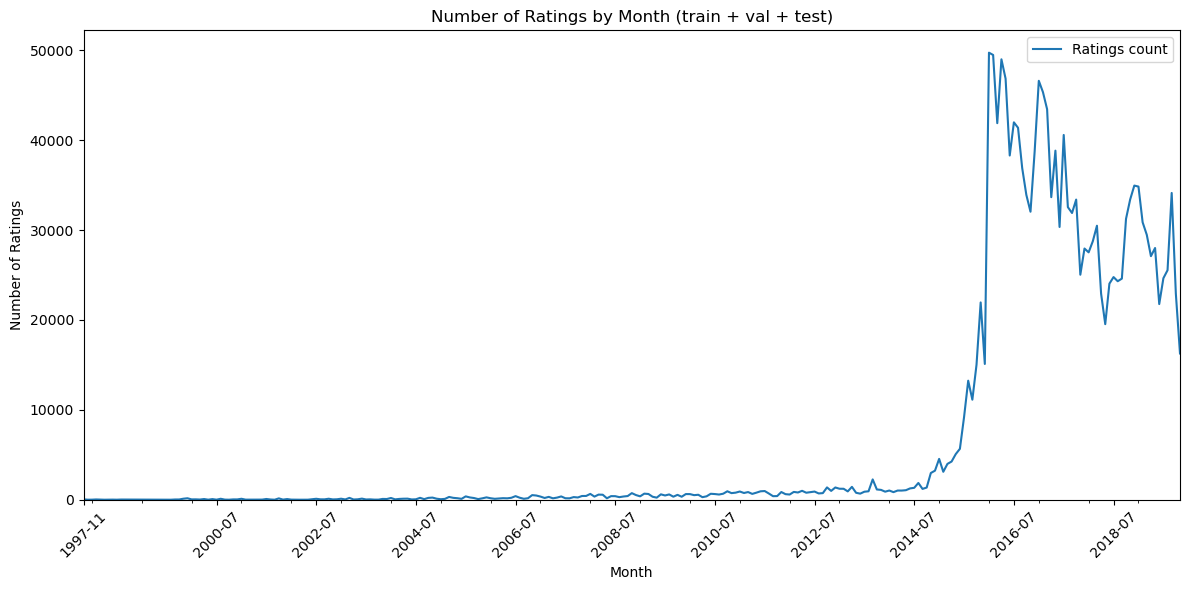

In [30]:
# Plot
plt.figure(figsize=(12, 6))
ratings_by_month.plot(kind='line', label='Ratings count')

plt.title('Number of Ratings by Month (train + val + test)')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')

# Compute percentages and counts for the legend and boxes
n_total = len(ratings_train) + len(ratings_val) + len(ratings_test)
counts = {'Train': len(ratings_train),
          'Validation': len(ratings_val),
          'Test': len(ratings_test)}
pcts = {k: round(v / n_total * 100) for k, v in counts.items()}

user_counts = {
    'Train': ratings_train['userId'].nunique(),
    'Validation': ratings_val['userId'].nunique(),
    'Test': ratings_test['userId'].nunique()
}

plt.legend()

# Show an x‑tick every two years
plt.xticks(ticks=ratings_by_month.index[::24],
           labels=ratings_by_month.index[::24].astype(str),
           rotation=45)

plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.tight_layout()

# Save plot
output_dir = '../plots/'
os.makedirs(output_dir, exist_ok=True)
filename = 'ratings_by_month'
if get_smaller_dataset:
    filename = filename + '_small'
plt.savefig(os.path.join(output_dir, f'{filename}.png'),
            dpi=300, bbox_inches='tight')
plt.show()

## Save dataframes

In [31]:
# Final stats
print("Number of positive ratings in the training set:", ratings_train['positive_rating'].sum())
print("Number of positive ratings in the validation set:", ratings_val['positive_rating'].sum())
print("Number of positive ratings in the test set:", ratings_test['positive_rating'].sum())
print("Number of positive ratings in the cold validation dataset:", ratings_subset_cold_start_val['positive_rating'].sum())
print("Number of positive ratings in the cold test dataset:", ratings_subset_cold_start_test['positive_rating'].sum())
print("\n")

print("Number of unique users in the training set:", ratings_train['userId'].nunique())
print("Number of unique users in the validation set:", ratings_val['userId'].nunique())
print("Number of unique users in the test set:", ratings_test['userId'].nunique())
print("Number of unique users in the cold validation dataset:", ratings_subset_cold_start_val['userId'].nunique())
print("Number of unique users in the cold test dataset:", ratings_subset_cold_start_test['userId'].nunique())
print("\n")

print("Number of unique movies in the training set:", ratings_train['movieId'].nunique())
print("Number of unique movies in the validation set:", ratings_val['movieId'].nunique())
print("Number of unique movies in the test set:", ratings_test['movieId'].nunique())
print("Number of unique movies in the cold validation dataset:", ratings_subset_cold_start_val['movieId'].nunique())
print("Number of unique movies in the cold test dataset:", ratings_subset_cold_start_test['movieId'].nunique())

Number of positive ratings in the training set: 896441
Number of positive ratings in the validation set: 291396
Number of positive ratings in the test set: 324979
Number of positive ratings in the cold validation dataset: 31193
Number of positive ratings in the cold test dataset: 37197


Number of unique users in the training set: 28083
Number of unique users in the validation set: 28083
Number of unique users in the test set: 28083
Number of unique users in the cold validation dataset: 11496
Number of unique users in the cold test dataset: 13205


Number of unique movies in the training set: 4056
Number of unique movies in the validation set: 4054
Number of unique movies in the test set: 4055
Number of unique movies in the cold validation dataset: 176
Number of unique movies in the cold test dataset: 176


In [32]:
# Output directory
output_dir = '../processed_data/'
os.makedirs(output_dir, exist_ok=True)

# Add suffix if get_smaller_dataset is True
def suffix_filename(filename, get_smaller_dataset):
    if get_smaller_dataset:
        base, ext = os.path.splitext(filename)
        return f"{base}_small{ext}"
    return filename

# Ratings
ratings_train.to_csv(suffix_filename(
    os.path.join(output_dir, 'ratings_train.csv'), get_smaller_dataset), index=False)
ratings_val.to_csv(suffix_filename(
    os.path.join(output_dir, 'ratings_val.csv'), get_smaller_dataset), index=False)
ratings_test.to_csv(suffix_filename(
    os.path.join(output_dir, 'ratings_test.csv'), get_smaller_dataset), index=False)

ratings_subset_cold_start_val.to_csv(suffix_filename(
    os.path.join(output_dir, 'ratings_cold_val.csv'), get_smaller_dataset), index=False)
ratings_subset_cold_start_test.to_csv(suffix_filename(
    os.path.join(output_dir, 'ratings_cold_test.csv'), get_smaller_dataset), index=False)

# Movies
movies_subset.to_csv(suffix_filename(
    os.path.join(output_dir, 'movies_warm.csv'), get_smaller_dataset), index=False)
movies_subset_cold_start_val.to_csv(suffix_filename(
    os.path.join(output_dir, 'movies_cold_val.csv'), get_smaller_dataset), index=False)
movies_subset_cold_start_test.to_csv(suffix_filename(
    os.path.join(output_dir, 'movies_cold_test.csv'), get_smaller_dataset), index=False)

# Genome scores
genome_scores_subset.to_csv(suffix_filename(
    os.path.join(output_dir, 'genome_scores_processed.csv'), get_smaller_dataset), index=False)

if get_smaller_dataset:
    print("Saved smaller dataset.")
else:
    print("Saved entire dataset.")

Saved entire dataset.
